In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [01:14<00:00, 1184.29it/s]


In [24]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

In [25]:
final["UPDATEDTEXT"]=preprocessed_reviews

In [26]:
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...


In [28]:
final['text_len'] = final['UPDATEDTEXT'].str.len()

In [29]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [30]:
df=pd.DataFrame(final)

In [31]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,My dogs loves this chicken but its a product f...,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,Our dogs just love them. I saw them in a pet ...,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,"I had an infestation of fruitflies, they were ...",infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,Worst product I have gotten in long time. Woul...,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,I wish I'd read the reviews before making this...,wish would read reviews making purchase basica...,277


In [32]:
df.drop("Text",axis = 1, inplace = True)

In [33]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,0,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [34]:
Y1=df["Score"]

In [35]:
df.drop("Score",axis = 1, inplace = True)

In [36]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,UPDATEDTEXT,text_len
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,1192060800,made in china,dogs loves chicken product china wont buying a...,162
22621,24751,2734888454,A1C298ITT645B6,Hugh G. Pritchard,0,0,1195948800,Dog Lover Delites,dogs love saw pet store tag attached regarding...,72
70677,76870,B00002N8SM,A19Q006CSFT011,Arlielle,0,0,1288396800,only one fruitfly stuck,infestation fruitflies literally everywhere fl...,406
70676,76869,B00002N8SM,A1FYH4S02BW7FN,wonderer,0,0,1290038400,Doesn't work!! Don't waste your money!!,worst product gotten long time would rate no s...,209
70675,76868,B00002N8SM,AUE8TB5VHS6ZV,eyeofthestorm,0,0,1306972800,A big rip off,wish would read reviews making purchase basica...,277
70673,76866,B00002N8SM,A3R3T5T1K8IN6P,LILIAN J. DE CIAFFI,0,0,1315785600,THIS ITEM IS EXCELLENT TO KILL INSECTS,happy item many flies disturbing kitchen put p...,84
70672,76865,B00002N8SM,A11DU8T1ZXPRT7,Zoggdogg,0,0,1319241600,Didn't work,thing item trapped fruit flies not work fly tr...,68
70671,76864,B00002N8SM,A71C9WY0242QU,MeMeMe,0,0,1325376000,Gross but effective,nurturing plant work well decided repot larger...,495
70670,76863,B00002N8SM,A17UIV0KM8JSV,S. Cohen,0,0,1337644800,Didn't work for me.,placed around house several days setup fly att...,255
70669,76862,B00002N8SM,A5W8ZREO7C1WK,Mireille,0,0,1340582400,Waste of money,please not waste money fly trap absolutely use...,196


In [37]:
df1=df.drop(df.columns[[0,1,2,3,4,5,6,7]],axis=1)


In [38]:
df1.head()

,UPDATEDTEXT,text_len
22620,dogs loves chicken product china wont buying a...,162
22621,dogs love saw pet store tag attached regarding...,72
70677,infestation fruitflies literally everywhere fl...,406
70676,worst product gotten long time would rate no s...,209
70675,wish would read reviews making purchase basica...,277


In [39]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df1, Y1, test_size=0.2, shuffle=False)
X1_train, X1_cv, Y1_train, Y1_cv = train_test_split(X1_train, Y1_train, test_size=0.2,shuffle=False)

In [40]:
print(X1_train.shape, Y1_train.shape)
print(X1_cv.shape, Y1_cv.shape)
print(X1_test.shape, Y1_test.shape)

(56174, 2) (56174,)
(14044, 2) (14044,)
(17555, 2) (17555,)


In [41]:
X1_train["UPDATEDTEXT"]

22620    dogs loves chicken product china wont buying a...
22621    dogs love saw pet store tag attached regarding...
70677    infestation fruitflies literally everywhere fl...
70676    worst product gotten long time would rate no s...
70675    wish would read reviews making purchase basica...
70673    happy item many flies disturbing kitchen put p...
70672    thing item trapped fruit flies not work fly tr...
70671    nurturing plant work well decided repot larger...
70670    placed around house several days setup fly att...
70669    please not waste money fly trap absolutely use...
70668    let put way flies stay traps left looks like s...
70661    not know product performs big flies sucks frui...
70667    flies buzz around thing like not even many fli...
70666    horrible product first item not work week lots...
70665    never caught even one fly got inside left week...
70662    ineffective worthless bought product indoors t...
70663    problem lot fruit flies kitchen picked one tak.

## [1]  BOW

In [42]:
count_vect = CountVectorizer(min_df=10)
X_train_BOW = count_vect.fit_transform(X1_train["UPDATEDTEXT"])
X_train_BOW.shape


(56174, 9284)

In [43]:
X_cv_BOW = count_vect.transform(X1_cv["UPDATEDTEXT"])
X_cv_BOW.shape

(14044, 9284)

In [44]:
X_test_BOW = count_vect.transform(X1_test["UPDATEDTEXT"])
X_test_BOW.shape

(17555, 9284)

In [45]:
from sklearn.preprocessing import normalize
trainb_text_feature_norm = normalize(X_train_BOW , axis=0)

cvb_text_feature_norm=normalize(X_cv_BOW,axis=0)

testb_text_feature_norm=normalize(X_test_BOW,axis=0)


In [46]:
trainb_text_feature_norm.shape

(56174, 9284)

In [47]:
cvb_text_feature_norm.shape

(14044, 9284)

In [48]:
testb_text_feature_norm.shape

(17555, 9284)

alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.813981046541888
0.0001   -4.0 -----> 0.8179909325747132
0.001   -3.0 -----> 0.8234668624228382
0.01   -2.0 -----> 0.8324853919372963
0.1   -1.0 -----> 0.8505916118004537
1   0.0 -----> 0.8670172738739106
10   1.0 -----> 0.7560385106852587
100   2.0 -----> 0.6520087526317085
1000   3.0 -----> 0.6337202193285493
10000   4.0 -----> 0.631716971077105
100000   5.0 -----> 0.6315143204574827


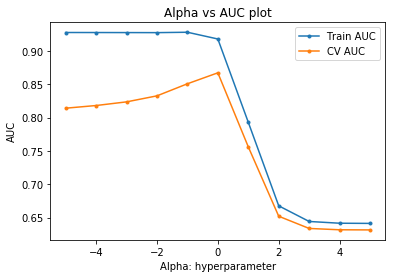

In [55]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mnb = MultinomialNB(alpha = i,fit_prior = False)
    Mnb.fit(trainb_text_feature_norm, Y1_train)
    
    Y_train_pred =  Mnb.predict_proba(trainb_text_feature_norm)[:,1]
    Y_cv_pred =  Mnb.predict_proba(cvb_text_feature_norm)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)
#plt.ylim([0.00001,100000])
plt.plot(np.log10(alpha), train_auc, label='Train AUC',marker = '.')
plt.plot(np.log10(alpha), cv_auc, label='CV AUC',marker = '.')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

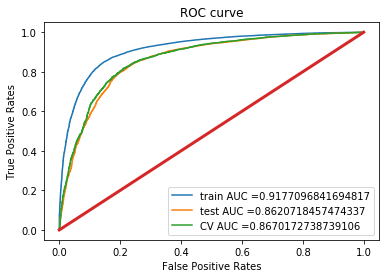

In [60]:
from sklearn.metrics import roc_curve, auc


Mbow = MultinomialNB(alpha = 1,fit_prior = False)
Mbow.fit(trainb_text_feature_norm, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Mbow.predict_proba(trainb_text_feature_norm)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Mbow.predict_proba(testb_text_feature_norm)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Mbow.predict_proba(cvb_text_feature_norm)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=3.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()


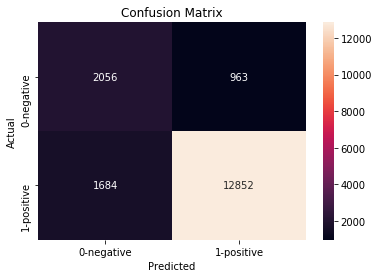

In [61]:
import seaborn as sb
C_b = confusion_matrix(Y1_test,Mbow.predict(testb_text_feature_norm))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


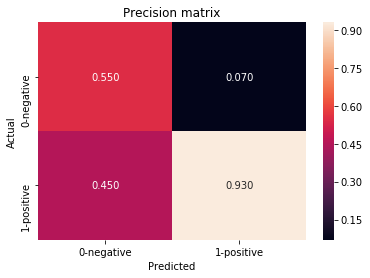

In [62]:
B_b =(C_b/C_b.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

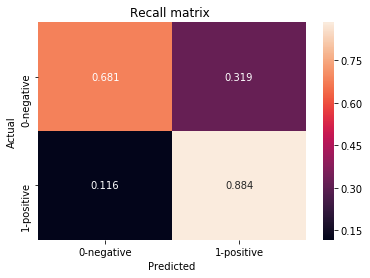

In [63]:
A_b =(((C_b.T)/(C_b.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [64]:
Positive_features = Mbow.feature_log_prob_[1,:]
Negative_features = Mbow.feature_log_prob_[0,:]

In [65]:
import operator
imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Positive_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -6.575627923228547)
('great', -6.604913083256277)
('good', -6.678941269745125)
('like', -6.749495714445874)
('love', -6.767079607243572)
('one', -6.8543068313929245)
('taste', -6.914624160964259)
('flavor', -6.941190282357218)
('best', -6.9512320170321305)
('get', -6.973790196708675)


In [66]:
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Negative_features[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('not', -6.53097333090146)
('would', -6.946311483087533)
('product', -6.9697626978275355)
('like', -7.000948057902262)
('taste', -7.022623975106647)
('bad', -7.114085969139938)
('disappointed', -7.131700146132756)
('one', -7.194597856814961)
('money', -7.204702536592601)
('no', -7.208331245315948)


## FEATURE SELECTION

#### BY USING PERCENTILE
#from sklearn.feature_selection import SelectPercentile,f_classif
#selector=SelectPercentile(f_classif,percentile=30)
#selector.fit(X_train_BOW,Y1_train)

#feature_train=selector.transform(X_train_BOW).toarray()
#feature_cv=selector.transform(X_cv_BOW).toarray()
#feature_test=selector.transform(X_test_BOW).toarray()

### Selecting top 2000 features using SelectKBest

In [67]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sel = SelectKBest(chi2, k=2000)
sel.fit(trainb_text_feature_norm,Y1_train)

SelectKBest(k=2000, score_func=<function chi2 at 0x000001AC1AE9F1E0>)

In [68]:
feature_train=sel.transform(trainb_text_feature_norm).toarray()
feature_cv=sel.transform(cvb_text_feature_norm).toarray()
feature_test=sel.transform(testb_text_feature_norm).toarray()

In [69]:
feature_train.shape

(56174, 2000)

In [70]:
feature_cv.shape

(14044, 2000)

In [71]:
feature_test.shape

(17555, 2000)

alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.8675610229875397
0.0001   -4.0 -----> 0.8676047623472553
0.001   -3.0 -----> 0.8678464286199792
0.01   -2.0 -----> 0.8689144190206862
0.1   -1.0 -----> 0.8703158814730422
1   0.0 -----> 0.8686720676302091
10   1.0 -----> 0.821707065356159
100   2.0 -----> 0.7282671363545512
1000   3.0 -----> 0.7027792775245788
10000   4.0 -----> 0.6996894685754336
100000   5.0 -----> 0.6993754682915063


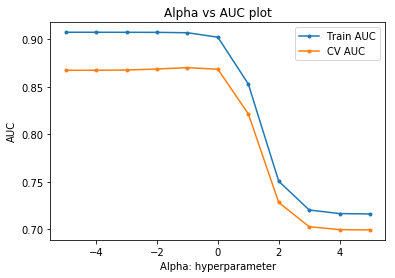

In [72]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc = []
cv_auc = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mnb = MultinomialNB(alpha = i,fit_prior = False)
    Mnb.fit(feature_train, Y1_train)
    
    Y_train_pred =  Mnb.predict_proba(feature_train)[:,1]
    Y_cv_pred =  Mnb.predict_proba(feature_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc.append(cv_auc_score)
#plt.ylim([0.00001,100000])
plt.plot(np.log10(alpha), train_auc, label='Train AUC',marker = '.')
plt.plot(np.log10(alpha), cv_auc, label='CV AUC',marker = '.')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

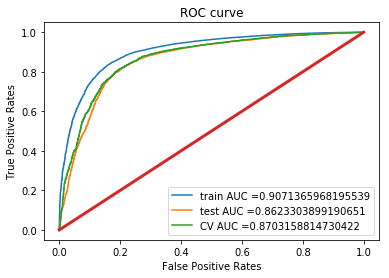

In [81]:
from sklearn.metrics import roc_curve, auc


Mbow = MultinomialNB(alpha = 0.1,fit_prior = False)
Mbow.fit(feature_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs


train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Mbow.predict_proba(feature_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Mbow.predict_proba(feature_test)[:,1])
cv_fpr,cv_tpr,thresholds = roc_curve(Y1_cv,Mbow.predict_proba(feature_cv)[:,1])
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.legend()
plt.plot([0,1],[0,1],linewidth=3.0)
plt.xlabel("False Positive Rates")
plt.ylabel("True Positive Rates")
plt.title("ROC curve")
plt.show()


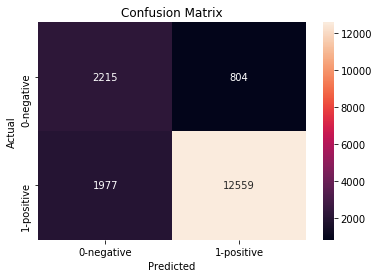

In [82]:
import seaborn as sb
C_b = confusion_matrix(Y1_test,Mbow.predict(feature_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

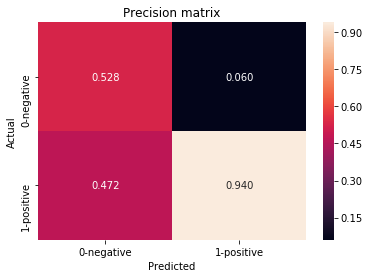

In [83]:
B_b =(C_b/C_b.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

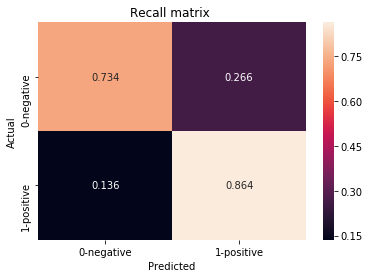

In [84]:
A_b =(((C_b.T)/(C_b.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_b, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Using New Feature Length

In [85]:
from sklearn.preprocessing import Normalizer
normalizer_count=Normalizer()
normalizer_count.fit(X1_train["text_len"].values.reshape(-1,1))

Normalizer(copy=True, norm='l2')

In [86]:
train_count=normalizer_count.transform(X1_train["text_len"].values.reshape(-1,1))
cv_count=normalizer_count.transform(X1_cv["text_len"].values.reshape(-1,1))
test_count=normalizer_count.transform(X1_test["text_len"].values.reshape(-1,1))

In [87]:
train_count.shape

(56174, 1)

In [88]:
cv_count.shape

(14044, 1)

In [89]:
test_count.shape

(17555, 1)

In [90]:
from scipy.sparse import hstack
train_x_hstackb = hstack((trainb_text_feature_norm, train_count)).tocsr()
train_y_hstackb = np.array(list(Y1_train))

In [91]:
cv_x_hstackb = hstack((cvb_text_feature_norm, cv_count)).tocsr()
cv_y_hstackb = np.array(list(Y1_cv))

In [92]:
test_x_hstackb = hstack((testb_text_feature_norm,test_count )).tocsr()
test_y_hstackb = np.array(list(Y1_test))

In [93]:
print("(number of data points * number of features) in train data = ", train_x_hstackb.shape)
print("(number of data points * number of features) in test data = ", test_x_hstackb.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_hstackb.shape)

(number of data points * number of features) in train data =  (56174, 9285)
(number of data points * number of features) in test data =  (17555, 9285)
(number of data points * number of features) in cross validation data = (14044, 9285)


alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.8201539935567921
0.0001   -4.0 -----> 0.824373273210284
0.001   -3.0 -----> 0.8300225378499613
0.01   -2.0 -----> 0.8388934064591964
0.1   -1.0 -----> 0.8584858270231284
1   0.0 -----> 0.8481149111227388
10   1.0 -----> 0.777599815436489
100   2.0 -----> 0.7475118957175777
1000   3.0 -----> 0.7333065921056622
10000   4.0 -----> 0.7312029921327928
100000   5.0 -----> 0.730979391333455


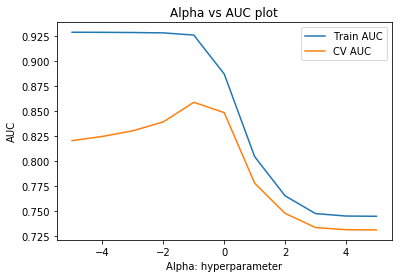

In [94]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mbow_h= MultinomialNB(alpha = i,fit_prior = False)
    Mbow_h.fit(train_x_hstackb, train_y_hstackb)
    
    Y_train_pred =  Mbow_h.predict_proba(train_x_hstackb)[:,1]
    Y_cv_pred =  Mbow_h.predict_proba(cv_x_hstackb)[:,1]
    train_auc_score=roc_auc_score(train_y_hstackb,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(cv_y_hstackb, Y_cv_pred)
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(np.log10(alpha), train_auc_t, label='Train AUC')
plt.plot(np.log10(alpha), cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

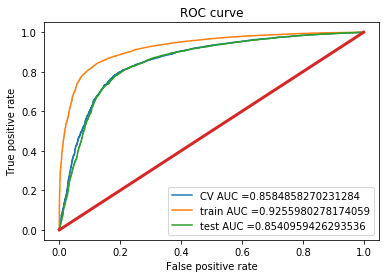

In [114]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


Mbown = MultinomialNB(alpha = 0.1,fit_prior = False)
Mbown.fit(train_x_hstackb, train_y_hstackb)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(cv_y_hstackb,Mbown.predict_proba(cv_x_hstackb)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(train_y_hstackb, Mbown.predict_proba(train_x_hstackb)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(test_y_hstackb, Mbown.predict_proba(test_x_hstackb)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()


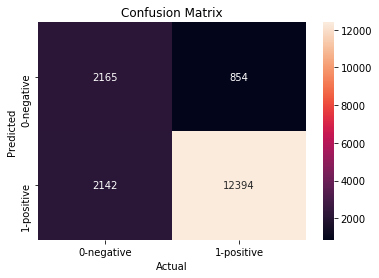

In [115]:
import seaborn as sb
C_bow = confusion_matrix(test_y_hstackb,Mbown.predict(test_x_hstackb))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()


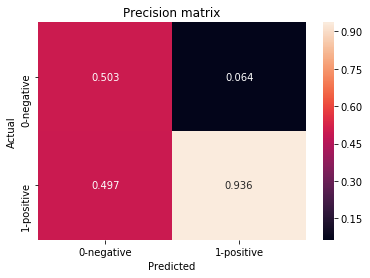

In [116]:
B_bow =(C_bow/C_bow.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


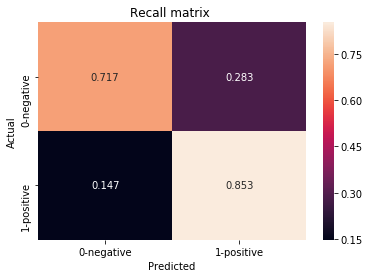

In [117]:
A_bow =(((C_bow.T)/(C_bow.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A_bow, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [118]:
Positive_features_n = Mbown.feature_log_prob_[1,:]
Negative_features_n = Mbown.feature_log_prob_[0,:]

In [119]:
imp_features = {}
feature_names= count_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Positive_features_n[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -6.999123618233719)
('great', -7.028664723094035)
('good', -7.103374647319016)
('like', -7.17462801776878)
('love', -7.192393992779617)
('one', -7.280573886872819)
('taste', -7.341600893151531)
('flavor', -7.3684935911455645)
('best', -7.378661074150264)
('get', -7.401506446639891)


In [120]:
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Negative_features_n[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('not', -6.573414766241231)
('would', -7.002238895328331)
('product', -7.0266384374794235)
('like', -7.059121285135061)
('taste', -7.0817242083970005)
('bad', -7.177337258434687)
('disappointed', -7.195797503941289)
('one', -7.261847277980037)
('money', -7.272478052620116)
('no', -7.276297057378333)


## OBSERVATIONS:

1] When we apply Multinomial Naive Bayes to BOW we get Test AUC as 86.20.<br>
2] When we perform feature selection(top 2000 features) among 9284 features we get Test AUC as 86.28.<br>
3] On performing featurization we get Test AUC as 85.40.<br>
4] Multinomial Naive Bayes performed better than Knn on BOW

## [2] TFIDF

In [121]:
tf_idf_vect = TfidfVectorizer(min_df = 10, ngram_range = (1,2))
tf_idf_vect.fit(X1_train["UPDATEDTEXT"])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X1_train_tfidf = tf_idf_vect.transform(X1_train["UPDATEDTEXT"])
print("the type of count vectorizer ",type(X1_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X1_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X1_train_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aafco', 'abandon', 'abdominal', 'ability', 'able', 'able buy', 'able chew', 'able drink', 'able eat']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (56174, 32777)
the number of unique words including both unigrams and bigrams  32777


In [122]:
X1_cv_tfidf=tf_idf_vect.transform(X1_cv["UPDATEDTEXT"])
X1_cv_tfidf.shape

(14044, 32777)

In [123]:
X1_test_tfidf=tf_idf_vect.transform(X1_test["UPDATEDTEXT"])
X1_test_tfidf.shape

(17555, 32777)

In [124]:
from sklearn.preprocessing import normalize
train_text_feature_norm = normalize(X1_train_tfidf , axis=0)

cv_text_feature_norm=normalize(X1_cv_tfidf,axis=0)

test_text_feature_norm=normalize(X1_test_tfidf,axis=0)


In [125]:
train_text_feature_norm.shape

(56174, 32777)

In [126]:
cv_text_feature_norm.shape

(14044, 32777)

In [127]:
test_text_feature_norm.shape

(17555, 32777)

alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.848762347399486
0.0001   -4.0 -----> 0.8620240275123097
0.001   -3.0 -----> 0.8795736432892591
0.01   -2.0 -----> 0.9014753073284991
0.1   -1.0 -----> 0.9231936843393511
1   0.0 -----> 0.932115540132954
10   1.0 -----> 0.9024340394769899
100   2.0 -----> 0.836654405583003
1000   3.0 -----> 0.8173835576571122
10000   4.0 -----> 0.8149332159834798
100000   5.0 -----> 0.8146825710623065


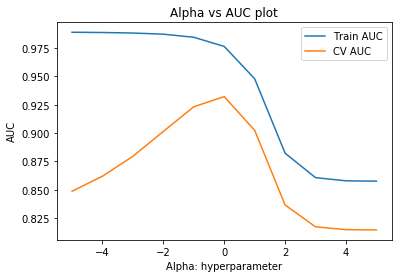

In [128]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
train_auc_t = []
cv_auc_t = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mtfidf =MultinomialNB(alpha = i,fit_prior = False)
    Mtfidf.fit(train_text_feature_norm, Y1_train)
    
    Y_train_pred =  Mtfidf.predict_proba(train_text_feature_norm)[:,1]
    Y_cv_pred =  Mtfidf.predict_proba(cv_text_feature_norm)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(np.log10(alpha), train_auc_t, label='Train AUC')
plt.plot(np.log10(alpha), cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

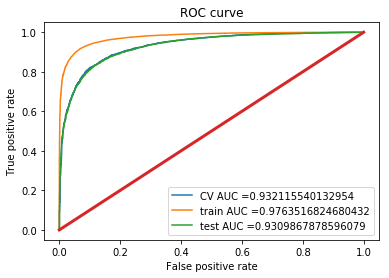

In [129]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


Mtfidf1 =MultinomialNB(alpha = 1,fit_prior = False)
Mtfidf1.fit(train_text_feature_norm, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,Mtfidf1.predict_proba(cv_text_feature_norm)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Mtfidf1.predict_proba(train_text_feature_norm)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Mtfidf1.predict_proba(test_text_feature_norm)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

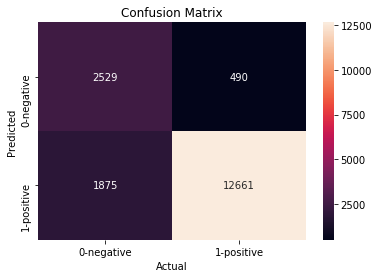

In [130]:
import seaborn as sb
C_t = confusion_matrix(Y1_test,Mtfidf1.predict(test_text_feature_norm))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

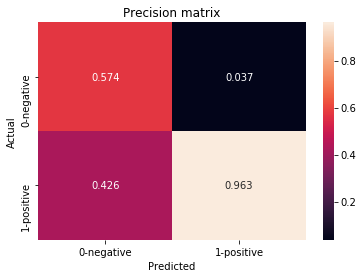

In [131]:
B =(C_t/C_t.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

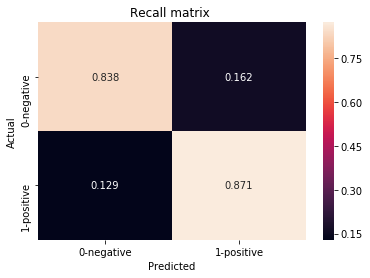

In [132]:
A =(((C_t.T)/(C_t.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [133]:
Positive_features_t = Mtfidf1.feature_log_prob_[1,:]
Negative_features_t = Mtfidf1.feature_log_prob_[0,:]

In [134]:
import operator
imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Positive_features_t[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -7.379860052973118)
('great', -7.525904687213078)
('good', -7.558872859566983)
('like', -7.61588158055979)
('love', -7.689168918203227)
('one', -7.719770238463394)
('taste', -7.787055910454703)
('flavor', -7.797397970786566)
('product', -7.8424470684926755)
('would', -7.854653195750899)


In [135]:
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Negative_features_t[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('not', -7.360186952713487)
('would', -7.88052413097361)
('like', -7.9323190120825675)
('taste', -7.9761518939439915)
('product', -8.013504769268309)
('bad', -8.08041113723279)
('disappointed', -8.101471233802306)
('one', -8.17097244701374)
('would not', -8.176625446964355)
('no', -8.194356817870478)


# FEATURE SELECTION

### Selecting top 2000 features using SelectKBest

In [136]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
sel1 = SelectKBest(chi2, k=10000)
sel1.fit(train_text_feature_norm,Y1_train)

SelectKBest(k=10000, score_func=<function chi2 at 0x000001AC1AE9F1E0>)

In [137]:
feature_train=sel1.transform(train_text_feature_norm).toarray()
feature_cv=sel1.transform(cv_text_feature_norm).toarray()
feature_test=sel1.transform(test_text_feature_norm).toarray()

alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.8602432982953296
0.0001   -4.0 -----> 0.8697200994690013
0.001   -3.0 -----> 0.8823508221899833
0.01   -2.0 -----> 0.8993713107085095
0.1   -1.0 -----> 0.9191962386025704
1   0.0 -----> 0.9310757116777852
10   1.0 -----> 0.9220742019306689
100   2.0 -----> 0.8867467179884769
1000   3.0 -----> 0.8717152344838949
10000   4.0 -----> 0.8695535076784933
100000   5.0 -----> 0.8693300871733012


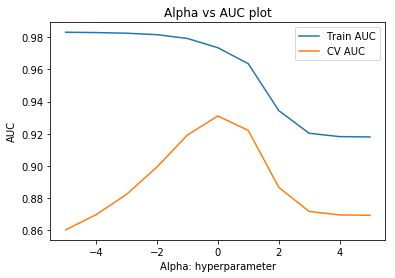

In [138]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mtfidf =MultinomialNB(alpha = i,fit_prior = False)
    Mtfidf.fit(feature_train, Y1_train)
    
    Y_train_pred =  Mtfidf.predict_proba(feature_train)[:,1]
    Y_cv_pred =  Mtfidf.predict_proba(feature_cv)[:,1]
    train_auc_score=roc_auc_score(Y1_train,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(Y1_cv, Y_cv_pred)
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(np.log10(alpha), train_auc_t, label='Train AUC')
plt.plot(np.log10(alpha), cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

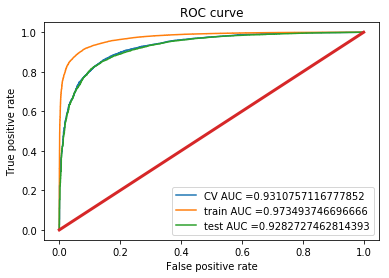

In [139]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


Mtfidf1 =MultinomialNB(alpha = 1,fit_prior = False)
Mtfidf1.fit(feature_train, Y1_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(Y1_cv,Mtfidf1.predict_proba(feature_cv)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(Y1_train, Mtfidf1.predict_proba(feature_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(Y1_test, Mtfidf1.predict_proba(feature_test)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

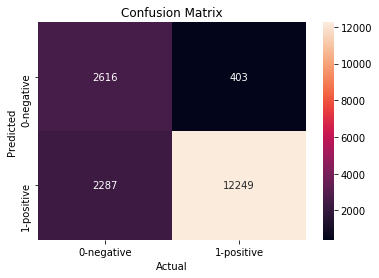

In [140]:
import seaborn as sb
C_t = confusion_matrix(Y1_test,Mtfidf1.predict(feature_test))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

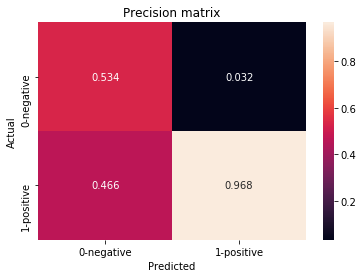

In [141]:
B =(C_t/C_t.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

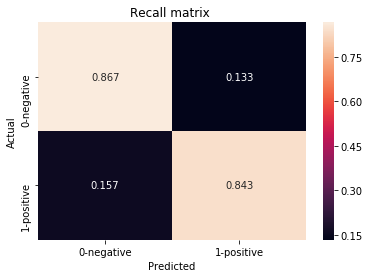

In [142]:
A =(((C_t.T)/(C_t.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Using new feature Length

In [143]:
from scipy.sparse import hstack
train_x_hstack = hstack((train_text_feature_norm, train_count)).tocsr()
train_y_hstack = np.array(list(Y1_train))

In [144]:
cv_x_hstack = hstack((cv_text_feature_norm, cv_count)).tocsr()
cv_y_hstack = np.array(list(Y1_cv))

In [145]:
test_x_hstack = hstack((test_text_feature_norm,test_count )).tocsr()
test_y_hstack = np.array(list(Y1_test))

In [146]:
print("(number of data points * number of features) in train data = ", train_x_hstack.shape)
print("(number of data points * number of features) in test data = ", test_x_hstack.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_hstack.shape)

(number of data points * number of features) in train data =  (56174, 32778)
(number of data points * number of features) in test data =  (17555, 32778)
(number of data points * number of features) in cross validation data = (14044, 32778)


alpha   log10(aplha) -----> CV AUC SCORE
----------------------------------------------------
1e-05   -5.0 -----> 0.8493768078770079
0.0001   -4.0 -----> 0.8627126429719052
0.001   -3.0 -----> 0.8803315638184122
0.01   -2.0 -----> 0.9022354274462283
0.1   -1.0 -----> 0.9237812990185976
1   0.0 -----> 0.9219505201468071
10   1.0 -----> 0.8966763098793367
100   2.0 -----> 0.8706585665555298
1000   3.0 -----> 0.8563663251066196
10000   4.0 -----> 0.8543214289075483
100000   5.0 -----> 0.8541036696385271


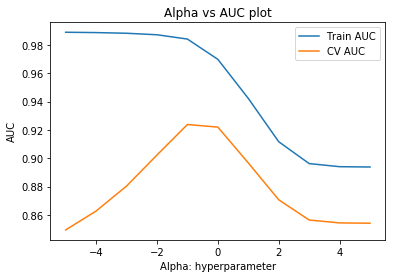

In [147]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_auc_t = []
cv_auc_t = []
alpha=[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000,100000]
print("alpha"," ","log10(aplha)","----->","CV AUC SCORE")
print("----------------------------------------------------")
for i in alpha:
    Mtfidf_n =MultinomialNB(alpha = i,fit_prior = False)
    Mtfidf_n.fit(train_x_hstack, Y1_train)
    Y_train_pred =  Mtfidf_n.predict_proba(train_x_hstack)[:,1]
    Y_cv_pred =  Mtfidf_n.predict_proba(cv_x_hstack)[:,1]
    train_auc_score=roc_auc_score(train_y_hstack,Y_train_pred)
    train_auc_t.append(train_auc_score)
    cv_auc_score=roc_auc_score(cv_y_hstack, Y_cv_pred)
    print(i," ",np.log10(i),"----->",cv_auc_score)
    cv_auc_t.append(cv_auc_score)

plt.plot(np.log10(alpha), train_auc_t, label='Train AUC')
plt.plot(np.log10(alpha), cv_auc_t, label='CV AUC')
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Alpha vs AUC plot")
plt.show()

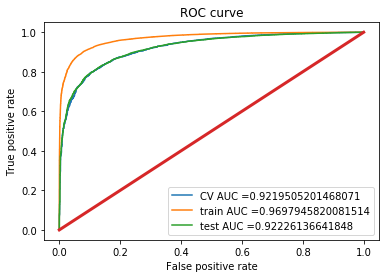

In [148]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


Mtfidf_n1 =MultinomialNB(alpha = 1,fit_prior = False)
Mtfidf_n1.fit(train_x_hstack, train_y_hstack)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

cv_fpr,cv_tpr,threshold = roc_curve(cv_y_hstack,Mtfidf_n1.predict_proba(cv_x_hstack)[:,1])
train_fpr, train_tpr, thresholds = roc_curve(train_y_hstack,Mtfidf_n1.predict_proba(train_x_hstack)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(test_y_hstack, Mtfidf_n1.predict_proba(test_x_hstack)[:,1])
plt.plot(cv_fpr, cv_tpr, label="CV AUC ="+str(auc(cv_fpr, cv_tpr)))
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],linewidth=3.0)
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.show()

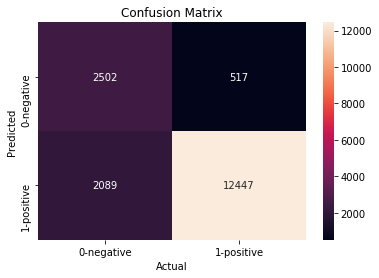

In [149]:
import seaborn as sb
C_t1 = confusion_matrix(test_y_hstack,Mtfidf_n1.predict(test_x_hstack))
class_label = ['0-negative', '1-positive']
df_conf_matrix = pd.DataFrame(
    C_t1, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

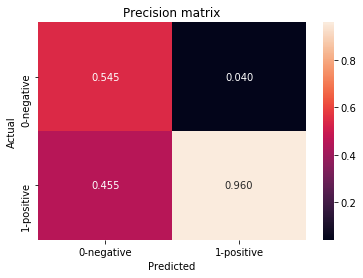

In [150]:
B =(C_t1/C_t1.sum(axis=0))
df_conf_matrix = pd.DataFrame(
    B, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Precision matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

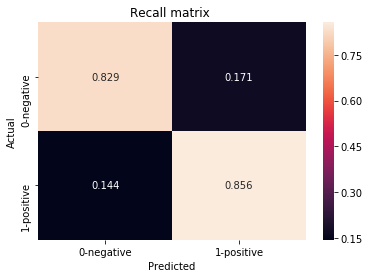

In [151]:
A =(((C_t1.T)/(C_t1.sum(axis=1))).T)
df_conf_matrix = pd.DataFrame(
    A, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='.3f')
plt.title("Recall matrix ")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [152]:
Positive_features_tn = Mtfidf_n1.feature_log_prob_[1,:]
Negative_features_tn = Mtfidf_n1.feature_log_prob_[0,:]

In [153]:
imp_features = {}
feature_names= tf_idf_vect.get_feature_names()
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Positive_features_tn[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("Postive top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])

Postive top 10 important features are:
('not', -7.606418371649484)
('great', -7.752463005889444)
('good', -7.785431178243349)
('like', -7.842439899236156)
('love', -7.915727236879593)
('one', -7.94632855713976)
('taste', -8.013614229131068)
('flavor', -8.023956289462932)
('product', -8.069005387169042)
('would', -8.081211514427265)


In [154]:
for i in range(len(feature_names)):
    imp_features[feature_names[i]] = Negative_features_tn[i]
names_diff_sorted = sorted(imp_features.items(), key = operator.itemgetter(1), reverse = True)
print("\n\nNegative top 10 important features are:")
for i in range(10):
    print(names_diff_sorted[i])



Negative top 10 important features are:
('not', -7.4899131803248125)
('would', -8.010250358584935)
('like', -8.062045239693893)
('taste', -8.105878121555318)
('product', -8.143230996879634)
('bad', -8.210137364844115)
('disappointed', -8.23119746141363)
('one', -8.300698674625066)
('would not', -8.30635167457568)
('no', -8.324083045481803)


## OBSERVATIONS

1] When we apply Multinomial Naive Bayes to Tfidf we get Test AUC as 93.09.<br>
2] When we perform feature selection(top 10000 features) among 32777 features we get Test AUC as 92.82.<br>
3] On performing featurization we get Test AUC as 92.22.<br>
4] Multinomial Naive Bayes performed better than Knn on Tfidf

## CONCLUSIONS:

In [72]:
from prettytable import PrettyTable
    
x = PrettyTable(["Vectorizer", "Algorithm", "Best Hyperparameter:alpha","AUC score"])
x.align["Vectorizer"] = "l"
x.add_row(["BOW","Normal \n Feature Selection \n Featurization \n ------------","1\n0.1\n0.1","86.20\n86.23\n85.40"])
x.add_row(["tfidf","Normal \n Feature Selection \n Featurization \n ------------","1\n1\n1","93.09\n92.82\n92.22"])

print(x.get_string(title="NAIVE BAYES ON DIFFERENT FEATURIZATION"))

+--------------------------------------------------------------------------+
|                  NAIVE BAYES ON DIFFERENT FEATURIZATION                  |
+------------+---------------------+---------------------------+-----------+
| Vectorizer |      Algorithm      | Best Hyperparameter:alpha | AUC score |
+------------+---------------------+---------------------------+-----------+
| BOW        |       Normal        |             1             |   86.20   |
|            |  Feature Selection  |            0.1            |   86.23   |
|            |    Featurization    |            0.1            |   85.40   |
|            |     ------------    |                           |           |
| tfidf      |       Normal        |             1             |   93.09   |
|            |  Feature Selection  |             1             |   92.82   |
|            |    Featurization    |             1             |   92.22   |
|            |     ------------    |                           |           |

1] Multinomial Naive Bayes performed better  than KNN on Anazon Food Review Dataset.<br>
2] Naive Bayes with Tfidf model has more accuracy than BOW model here.<br>
3] In BOW Test AUC increased slightly when we perform feature selection.
